# Autoencoder implementation for face image regeneration

### Importing necessary libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import os

from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

### Load LFW dataset and split it into Train set and Test set (70%-30%)

In [75]:
lfw_dataset=sklearn.datasets.fetch_lfw_people(data_home='LFW/',resize=0.256,download_if_missing=True,slice_=None,color=True)
print(lfw_dataset.images.shape)
X=lfw_dataset.images
y=lfw_dataset.target

img_rows= X[0].shape[0]
img_cols=X[0].shape[1]

X=X.reshape(X.shape[0],img_rows,img_cols,3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

(13233, 64, 64, 3)


### Show how much image have Train set and Test set

In [76]:
print(f"Train Images: {X_train.shape}")
print(f"Test Images: {X_test.shape}")

Train Images: (9263, 64, 64, 3)
Test Images: (3970, 64, 64, 3)


### Print some image of Train set

                            TRAIN DATA                           


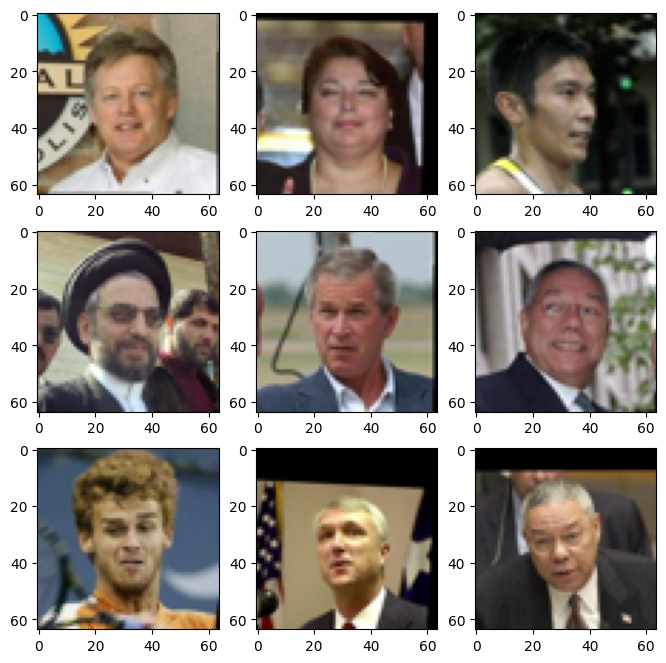

In [97]:
print("TRAIN DATA".center(65))
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i])
plt.show()

### Print some image of Test set

                            TEST DATA                            


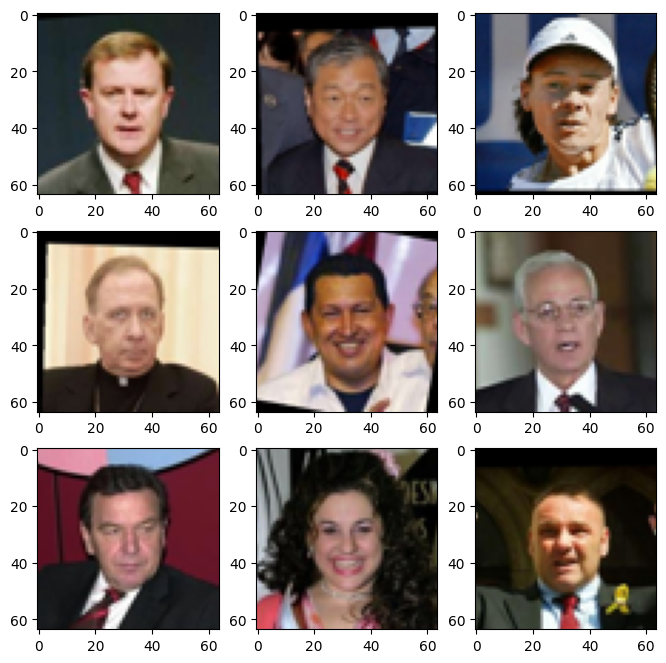

In [98]:
print("TEST DATA".center(65))
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
plt.show()

### Creating the Encoder Model

In [79]:
INPUT_LAYER = Input(shape = X_train.shape[1:], name="INPUT")

x = Conv2D(64,(3,3),activation='relu',padding="same")(INPUT_LAYER)
x = MaxPooling2D()(x)
x = Conv2D(32,(3,3),activation='relu',padding="same")(x)
x = MaxPooling2D()(x)

encoded = Conv2D(32,(3,3),activation='relu',padding="same", name="CODE")(x)

encoder_model = Model(INPUT_LAYER, encoded)

In [80]:
encoder_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 CODE (Conv2D)               (None, 16, 16, 32)        924

### Creating the Decoder Model

In [81]:
DECODER_INPUT = Input(shape = (16,16,32), name = "DECODER_INPUT")

x = Conv2DTranspose(16,(3,3),activation='relu',padding='same')(DECODER_INPUT)
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(8,(3,3),activation='sigmoid',padding='same')(x)
x = UpSampling2D((2,2))(x)

decoded = Conv2D(3, (3,3), padding='same', name="OUTPUT")(x)

decoder_model = Model(DECODER_INPUT, decoded)

In [72]:
decoder_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DECODER_INPUT (InputLayer)  [(None, 16, 16, 32)]      0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 16)       4624      
 ranspose)                                                       
                                                                 
 up_sampling2d_6 (UpSampling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 32, 32, 8)        1160      
 ranspose)                                                       
                                                                 
 up_sampling2d_7 (UpSampling  (None, 64, 64, 8)        0         
 2D)                                                      

### Ensemble the Autoencoder

In [82]:
AE_MODEL_INPUT = Input(shape = X_train.shape[1:])
encoder = encoder_model(AE_MODEL_INPUT)
decoder = decoder_model(encoder)

autoencoder_model = Model(AE_MODEL_INPUT, decoder)
autoencoder_model.compile(optimizer = "adam", loss="mse")
autoencoder_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 model_12 (Functional)       (None, 16, 16, 32)        29504     
                                                                 
 model_13 (Functional)       (None, 64, 64, 3)         6003      
                                                                 
Total params: 35,507
Trainable params: 35,507
Non-trainable params: 0
_________________________________________________________________


### Fit the model

In [83]:
autoencoder_model.fit(
    X_train,
    X_train,
    epochs = 100,
    batch_size = 32,
    validation_data = (X_test, X_test)
)

Epoch 1/100
290/290 [==============================] - 37s 124ms/step - loss: 0.0294 - val_loss: 0.0088
Epoch 2/100
290/290 [==============================] - 36s 123ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 3/100
290/290 [==============================] - 36s 124ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 4/100
290/290 [==============================] - 36s 124ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 5/100
290/290 [==============================] - 36s 125ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 6/100
290/290 [==============================] - 36s 124ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 7/100
290/290 [==============================] - 38s 131ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 8/100
290/290 [==============================] - 40s 136ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 9/100
290/290 [==============================] - 39s 136ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/100
290/290 [==============================] - 39s 134m

## Testing the Autoencoder
### Print Original Image from the Test set

                         ORIGINAL IMAGES                         


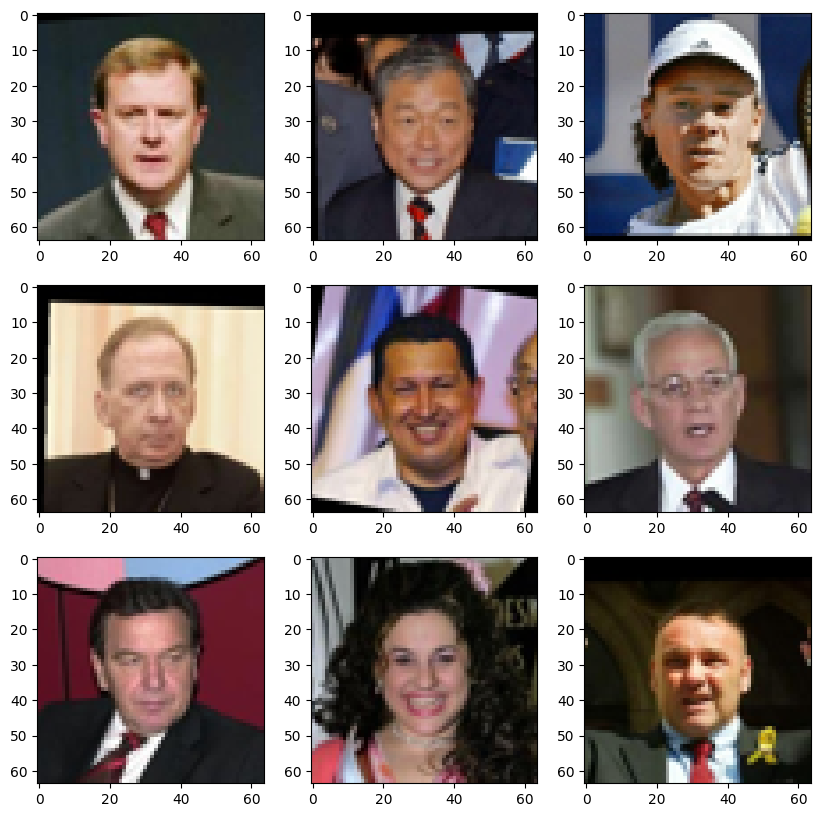

In [84]:
plt.figure(figsize = (10,10))
print("ORIGINAL IMAGES".center(65))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
plt.show()

### Print Reconstructed Image from the Test set

1/1 [==============================] - 0s 131ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                         GENERATED IMAGES                        


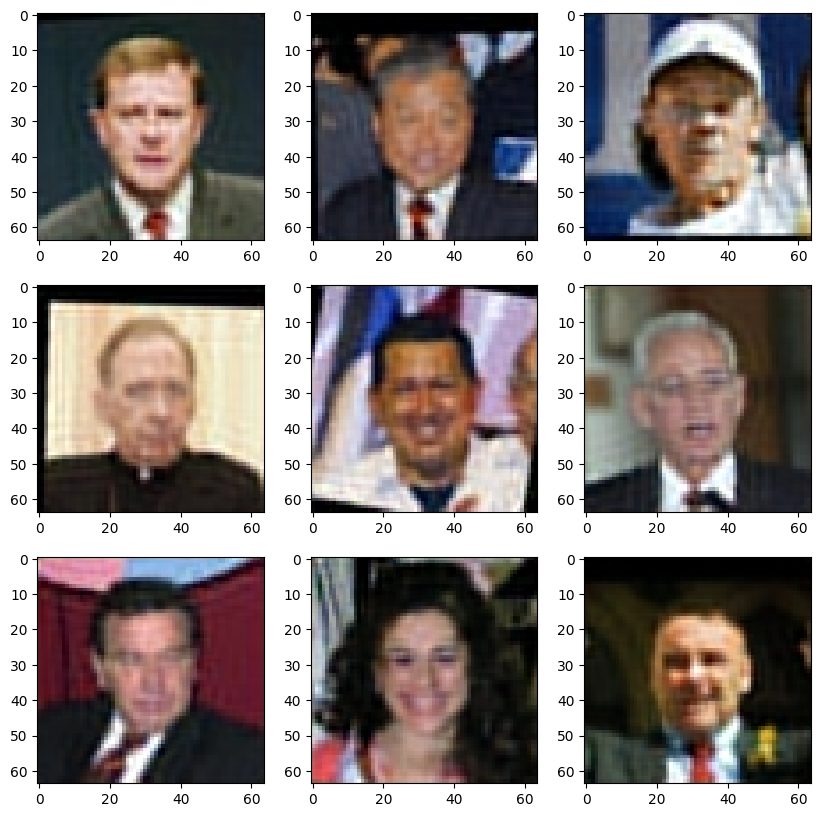

In [85]:
plt.figure(figsize = (10,10))
pred_images = autoencoder_model.predict(X_test[:9])
print("GENERATED IMAGES".center(65))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(pred_images[i])
plt.show()

### Evaluating the Autoencoder Model

In [87]:
NUMBER_OF_TEST_IMAGES = len(X_test)
mse = mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), generated_images.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
mae = mean_absolute_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), generated_images.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
rmse = np.sqrt(mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), generated_images.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3)))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.0016921541
Mean Absolute Error: 0.028074672
Root Mean Squared Error: 0.0411358


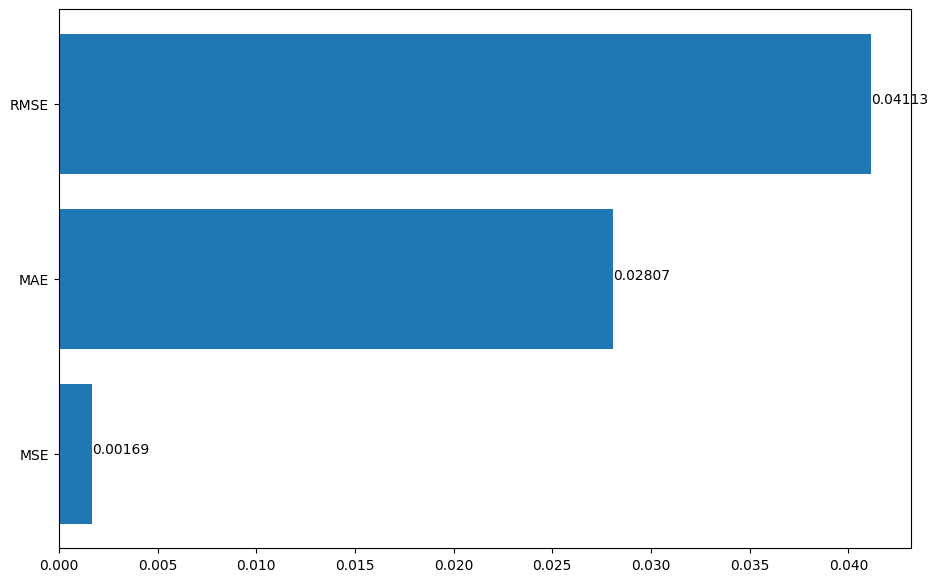

In [88]:
plt.figure(figsize = (11,7))
x = ["MSE","MAE","RMSE"]
y = [mse,mae,rmse]
plt.barh(x, y)
  
for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:7])
plt.show()